# Implementing a Multilayer Perceptron (MNIST)

## 1) Installing Libraries

In [1]:
# !conda install numpy pandas matplotlib --yes

In [2]:
# !pip install torch torchvision torchaudio

In [3]:
# !conda install watermark

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,torch

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.10.0

numpy     : 1.23.5
pandas    : 1.5.3
matplotlib: 3.7.0
torch     : 2.0.1



## 2) Loading the dataset

- MNIST website: http://yann.lecun.com/exdb/mnist/

In [5]:
# !pip install GitPython

import os
from git import Repo

if not os.path.exists("fashion-mnist"):
    Repo.clone_from("https://github.com/zalandoresearch/fashion-mnist", "fashion-mnist")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 4.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00


In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [19]:
from torch.utils.data import DataLoader, Dataset


class MyDataset(Dataset):
    def __init__(self, data_dir,kind, transform=None):

        self.transform = transform
        # ...
        self.images, self.labels = load_mnist(data_dir, kind=kind)

    def __getitem__(self, index):
        # ...
        img = self.images[index]
        img = torch.tensor(img).to(torch.float32)
        img = img/255.
        # ...
        label = self.labels[index]

        if self.transform is not None:
            img = self.transform(img)

        # ...
        return img, label

    def __len__(self):
        return self.labels.shape[0]

train_dataset = MyDataset(data_dir="fashion-mnist/data/fashion", kind="train")
test_dataset = MyDataset(data_dir="fashion-mnist/data/fashion", kind="t10k")

In [20]:
len(train_dataset)

60000

In [21]:
len(test_dataset)

10000

### Create a validation set

In [22]:
import torch
from torch.utils.data.dataset import random_split

torch.manual_seed(1)
train_dataset, val_dataset = random_split(train_dataset, lengths=[55000, 5000])

In [23]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

## 3) Implementing the model

In [24]:
import torch

class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(25, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

## 4) The training loop

In [25]:
def compute_accuracy(model, dataloader):

    model = model.eval()

    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(dataloader):

        with torch.no_grad():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)

        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [26]:
import torch.nn.functional as F

torch.manual_seed(1)
model = PyTorchMLP(num_features=784, num_classes=10)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 30

loss_list = []
train_acc_list, val_acc_list = [], []
for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        logits = model(features)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )
        loss_list.append(loss.item())

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

Epoch: 001/030 | Batch 000/860 | Train Loss: 2.29
Epoch: 001/030 | Batch 250/860 | Train Loss: 1.90
Epoch: 001/030 | Batch 500/860 | Train Loss: 1.26
Epoch: 001/030 | Batch 750/860 | Train Loss: 0.83
Train Acc 68.13% | Val Acc 68.92%
Epoch: 002/030 | Batch 000/860 | Train Loss: 0.90
Epoch: 002/030 | Batch 250/860 | Train Loss: 0.93
Epoch: 002/030 | Batch 500/860 | Train Loss: 0.77
Epoch: 002/030 | Batch 750/860 | Train Loss: 0.75
Train Acc 76.77% | Val Acc 76.88%
Epoch: 003/030 | Batch 000/860 | Train Loss: 0.91
Epoch: 003/030 | Batch 250/860 | Train Loss: 0.62
Epoch: 003/030 | Batch 500/860 | Train Loss: 0.58
Epoch: 003/030 | Batch 750/860 | Train Loss: 0.43
Train Acc 79.60% | Val Acc 80.12%
Epoch: 004/030 | Batch 000/860 | Train Loss: 0.68
Epoch: 004/030 | Batch 250/860 | Train Loss: 0.61
Epoch: 004/030 | Batch 500/860 | Train Loss: 0.39
Epoch: 004/030 | Batch 750/860 | Train Loss: 0.69
Train Acc 80.65% | Val Acc 80.94%
Epoch: 005/030 | Batch 000/860 | Train Loss: 0.68
Epoch: 005/030

## 5) Evaluating the results

In [27]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train Acc {train_acc*100:.2f}%")
print(f"Val Acc {val_acc*100:.2f}%")
print(f"Test Acc {test_acc*100:.2f}%")

Train Acc 87.67%
Val Acc 86.46%
Test Acc 85.68%


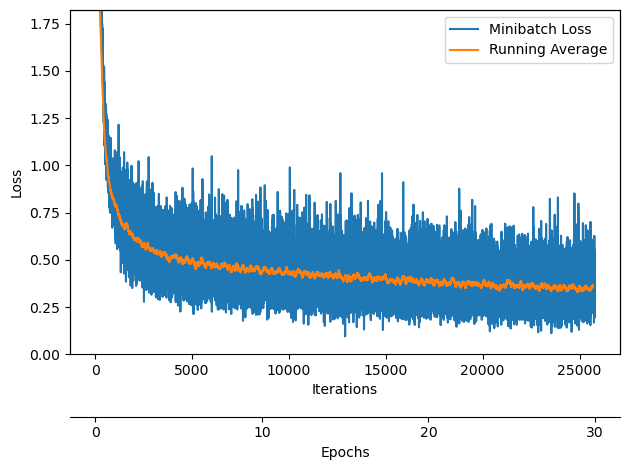

In [28]:
from helper_plotting import plot_training_loss

plot_training_loss(minibatch_loss_list=loss_list,
                   num_epochs=num_epochs,
                   iter_per_epoch=len(loss_list)//num_epochs)

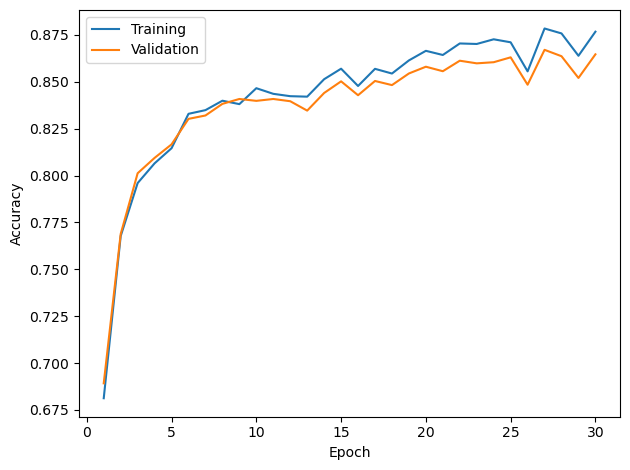

In [29]:
from helper_plotting import plot_accuracy

plot_accuracy(train_acc_list=train_acc_list, valid_acc_list=val_acc_list)